# Qualitative Evaluation Picker

In this notebook, some instances of the produced results are picked for qualitative evaluation

In [ ]:
import pandas as pd
import os
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
all_original_results = pd.read_csv('../results/allResults.csv')
all_custom_results = pd.read_csv('../results/allResults-custom.csv')

all_original_results.rename(columns={'index': 'id'}, inplace=True)
all_custom_results.rename(columns={'index': 'id'}, inplace=True)

There are 6 models: 
1. explanation
2. label
3. label-explanation

4. explanation-custom
5. label-custom
6. label-explanation-custom

In [ ]:
def exportSpecificRows(results, ids):
    '''Exports the rows with the given ids to a csv file
        
    Args:
        results: pandas dataframe with the results
        ids: list of ids to be exported
        filename: name of the file to be exported
    
    '''
    # results[results['id'].isin(ids)].sort_values(by=['id']).to_excel(filename, index=False)
    return results[results['id'].isin(ids)].sort_values(by=['id'])
    

In [ ]:
# Manually added the indexes here after they were generated by the sampler
ids_set_Amber_Leo = [259, 602, 1122, 1127, 1155, 1228, 1292, 1612, 1865, 2424, 2489, 3043, 3254, 3441, 3858, 4252, 4537, 4731, 4757,
                     4833, 5839, 5880, 5899, 6071, 6191, 6395, 6560, 7044, 7072, 7208, 7212, 7321, 7562, 7714, 8004, 8127, 8714, 8825, 9656, 9754]
ids_set_Lorenzo_Phillip = [148, 691, 793, 1289, 1296, 1545, 1625, 1780, 1847, 2187, 2316, 2553, 2622, 2646, 2670, 2676, 3230, 3272,
                           3401, 3550, 4211, 4584, 4906, 5015, 5374, 6278, 6670, 6878, 7060, 7465, 7480, 7743, 8347, 8770, 8827, 9295, 9488, 9575, 9656, 9714]

if not os.path.exists('../results/qualitativeEvaluation'):
    os.makedirs('../results/qualitativeEvaluation')

amber_leo_original_set = exportSpecificRows(
    all_original_results, ids_set_Amber_Leo)
lorenzo_phillip_original_set = exportSpecificRows(
    all_original_results, ids_set_Lorenzo_Phillip)

amber_leo_custom_set = exportSpecificRows(
    all_custom_results, ids_set_Amber_Leo)
lorenzo_phillip_custom_set = exportSpecificRows(
    all_custom_results, ids_set_Lorenzo_Phillip)

amber_leo_original_set.to_excel(
    '../results/qualitativeEvaluation/Amber_Leo_original.xlsx', index=False)
lorenzo_phillip_original_set.to_excel(
    '../results/qualitativeEvaluation/Lorenzo_Phillip_original.xlsx', index=False)

amber_leo_custom_set.to_excel(
    '../results/qualitativeEvaluation/Amber_Leo_custom.xlsx', index=False)
lorenzo_phillip_custom_set.to_excel(
    '../results/qualitativeEvaluation/Lorenzo_Phillip_custom.xlsx', index=False)

In [ ]:
def sampler(dataset, column_to_sort, samples_per_quartile = 2):
    '''Sample examples from each quartile of a dataset based on a column_to_sort
        
    Args:
        dataset: pandas dataframe with the results
        column_to_sort: column to sort the dataset by to use for quartile sampling
        samples_per_quartile: number of samples to take from each quartile
    
    Returns:
        pandas dataframe with the sampled examples
    '''
    # Quartile 1
    q1 = dataset[dataset[column_to_sort] <=
                    dataset[column_to_sort].quantile(0.25)]
    q1 = q1.sample(n=samples_per_quartile)

    # Quartile 2
    q2 = dataset[(dataset[column_to_sort] > dataset[column_to_sort].quantile(
        0.25)) & (dataset[column_to_sort] <= dataset[column_to_sort].quantile(0.5))]
    q2 = q2.sample(n=samples_per_quartile)

    # Quartile 3

    q3 = dataset[(dataset[column_to_sort] > dataset[column_to_sort].quantile(
        0.5)) & (dataset[column_to_sort] <= dataset[column_to_sort].quantile(0.75))]
    q3 = q3.sample(n=samples_per_quartile)

    # Quartile 4
    q4 = dataset[dataset[column_to_sort] >
                    dataset[column_to_sort].quantile(0.75)]
    q4 = q4.sample(n=samples_per_quartile)

    # Return concatenated dataframe

    return pd.concat([q1, q2, q3, q4])
    

In [ ]:
# Pick num_samples_per_quartile examples from each quartile based on neural score
# We use the explanation model instead of label-explanation. Hopefully that does not have a big impact for the sorting.
custom_sampled_results = sampler(all_custom_results, 'rug-nlp-nli/flan-base-nli-explanation-custom_neural_score', samples_per_quartile = 10)
#Pick the examplees with the same id from the original results
original_sampled_results = all_original_results[all_original_results['id'].isin(custom_sampled_results['id'])]    

masked_original_results = original_sampled_results[['id', 'premise', 'hypothesis',
                                      'label',
                                      'rug-nlp-nli/flan-base-nli-explanation_prediction', 
                                      'rug-nlp-nli/flan-base-nli-label-explanation_prediction'
                                      ]].copy()

masked_custom_results = custom_sampled_results[['id', 'premise', 'hypothesis',
                                      'label',
                                      'rug-nlp-nli/flan-base-nli-explanation-custom_prediction', 
                                      'rug-nlp-nli/flan-base-nli-label-explanation-custom_prediction'
                                      ]].copy()

# Rename the label column as correct_label for clarity
masked_original_results.rename(columns={'label': 'correct_label'}, inplace=True)
# Hide model names, to reduce bias in the qualitative evaluation
masked_original_results.rename(columns={'rug-nlp-nli/flan-base-nli-explanation_prediction': 'prediction_1'}, inplace=True)
masked_original_results.rename(columns={'rug-nlp-nli/flan-base-nli-label-explanation_prediction': 'prediction_2'}, inplace=True)

# Rename the label column as correct_label for clarity
masked_custom_results.rename(columns={'label': 'correct_label'}, inplace=True)
# Hide model names, to reduce bias in the qualitative evaluation
masked_custom_results.rename(columns={'rug-nlp-nli/flan-base-nli-explanation-custom_prediction': 'prediction_3'}, inplace=True)
masked_custom_results.rename(columns={'rug-nlp-nli/flan-base-nli-label-explanation-custom_prediction': 'prediction_4'}, inplace=True)

# Order based on id, so that it's easy to compare the two tables.
masked_original_results.sort_values(by=['id'], inplace=True)
masked_custom_results.sort_values(by=['id'], inplace=True)

In [ ]:
# Make a copy of the original results to add the custom results to.
all_qualitative_results = masked_original_results.copy()

# Copy prediction_3 and Prediction_4 to the original results
all_qualitative_results['prediction_3'] = masked_custom_results['prediction_3'].to_numpy()
all_qualitative_results['prediction_4'] = masked_custom_results['prediction_4'].to_numpy()

In [ ]:
# Export the two dataframes to two csvs
all_qualitative_results.to_csv('../results/results_for_qual_evaluation.csv')

In [ ]:
# Print the results from the original models, that use the full dataset
masked_original_results

In [ ]:
# Print the results from the custom models, that use the cleaned dataset
masked_custom_results

In [ ]:
# Import the results from the qualitative evaluation
qualitative_results = pd.read_csv('../results/qualitativeEvaluation/combined.csv')

qualitative_results

In [ ]:
# Do the Wilcoxon Sign-Ranked Test to see if there is a significant difference between the original and custom models
# We compare all models with each other

# Guide:
# prediction_1 = explanation-original
# prediction_2 = label-explanation-original
# prediction_3 = explanation-custom
# prediction_4 = label-explanation-custom

for i in range(1, 5):
    for j in range(i+1, 5):
        print('Comparing prediction_' + str(i) + ' vs prediction_' + str(j))
        print(stats.wilcoxon(qualitative_results['prediction_' + str(
            i) + '_score'], qualitative_results['prediction_' + str(j) + '_score']))


In [ ]:
# Now we can try to find the threshold of the neural score that gives correct explanations, based on the qualitative evaluation

# Gather all neural scores where the explanation is correct
correct_explanation_1 = qualitative_results[qualitative_results['Correct explanation_1?'] == 1]['explanation-original_neural_score']
incorrect_explanations_1 = qualitative_results[qualitative_results['Correct explanation_1?'] == 0]['explanation-original_neural_score']

fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([correct_explanation_1, incorrect_explanations_1], patch_artist = True)

ax.set_xticklabels(['Correct Explanations', 'Incorrect Explanations'])
ax.set_ylabel('Neural score')
 
# Adding title
plt.title("Neural scores for correct and incorrect explanations \n (explanation-original)")

Text(0.5, 1.0, 'Neural scores for correct and incorrect explanations \n (label-explanation-original)')

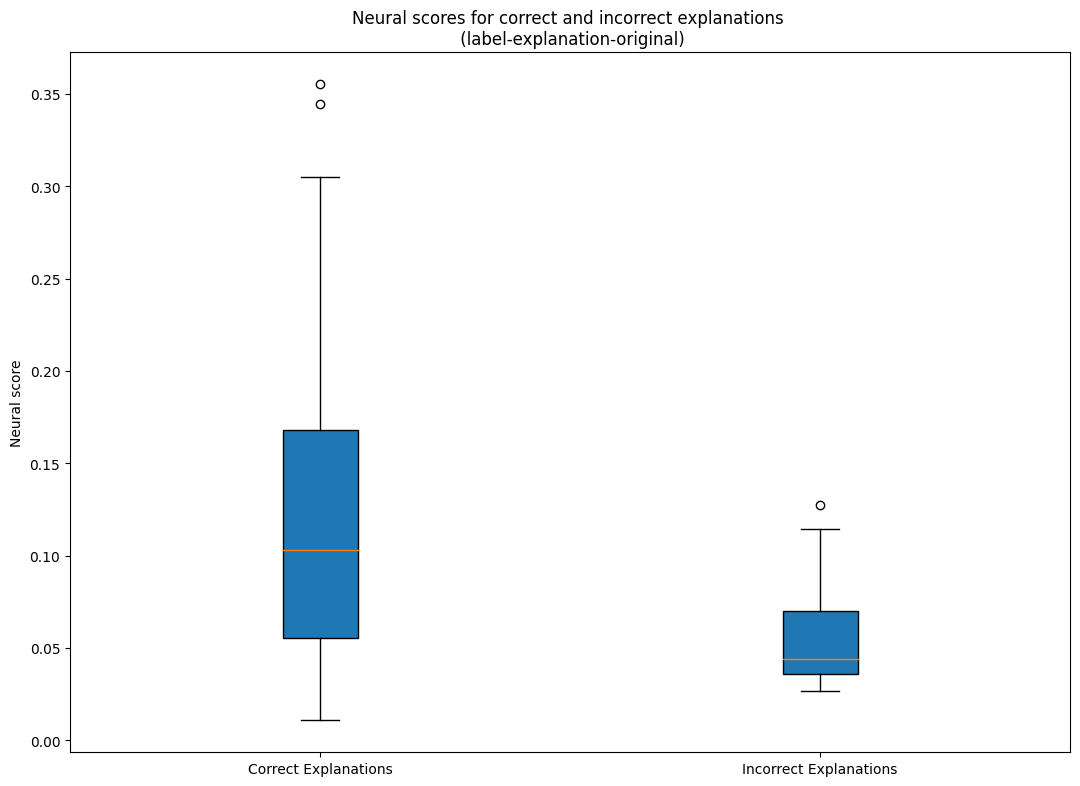

In [24]:
# Gather all neural scores where the explanation is correct
correct_explanation_2 = qualitative_results[qualitative_results['Correct explanation_2? '] == 1]['label-explanation-original_neural_score']
incorrect_explanations_2 = qualitative_results[qualitative_results['Correct explanation_2? '] == 0]['label-explanation-original_neural_score']

fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([correct_explanation_2, incorrect_explanations_2], patch_artist = True)

ax.set_xticklabels(['Correct Explanations', 'Incorrect Explanations'])
ax.set_ylabel('Neural score')
 
# Adding title
plt.title("Neural scores for correct and incorrect explanations \n (label-explanation-original)")

Text(0.5, 1.0, 'Neural scores for correct and incorrect explanations \n (explanation-custom)')

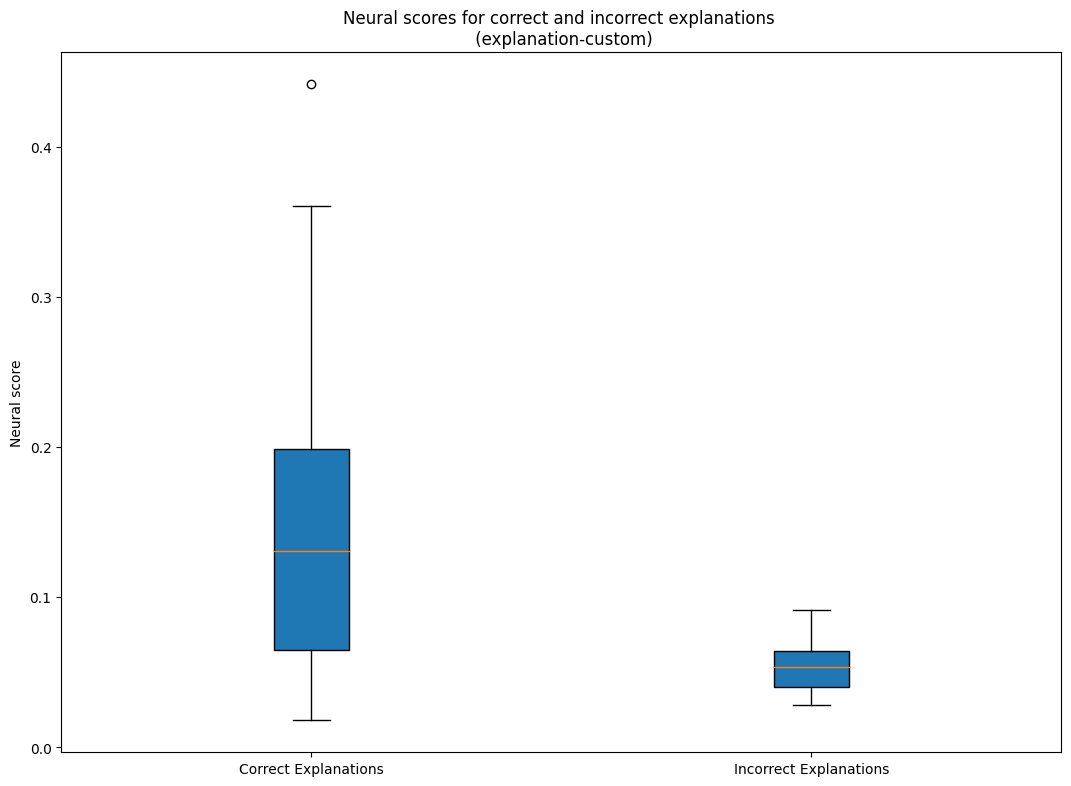

In [25]:
# Gather all neural scores where the explanation is correct
correct_explanation_3 = qualitative_results[qualitative_results['Correct explanation_3?'] == 1]['explanation-custom_neural_score']
incorrect_explanations_3 = qualitative_results[qualitative_results['Correct explanation_3?'] == 0]['explanation-custom_neural_score']

fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([correct_explanation_3, incorrect_explanations_3], patch_artist = True)

ax.set_xticklabels(['Correct Explanations', 'Incorrect Explanations'])
ax.set_ylabel('Neural score')
 
# Adding title
plt.title("Neural scores for correct and incorrect explanations \n (explanation-custom)")

Text(0.5, 1.0, 'Neural scores for correct and incorrect explanations \n (label-explanation-custom)')

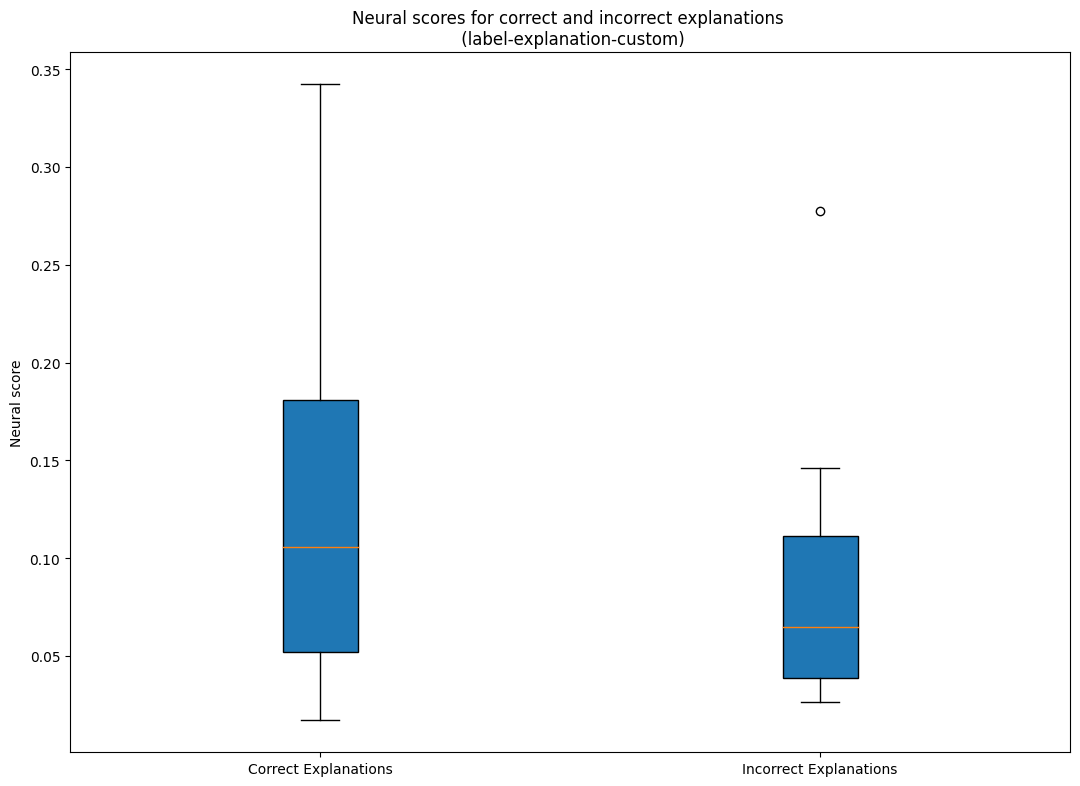

In [26]:
# Gather all neural scores where the explanation is correct
correct_explanation_4 = qualitative_results[qualitative_results['Correct explanation_4? '] == 1]['label-explanation-custom_neural_score']
incorrect_explanations_4 = qualitative_results[qualitative_results['Correct explanation_4? '] == 0]['label-explanation-custom_neural_score']

fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([correct_explanation_4, incorrect_explanations_4], patch_artist = True)

ax.set_xticklabels(['Correct Explanations', 'Incorrect Explanations'])
ax.set_ylabel('Neural score')
 
# Adding title
plt.title("Neural scores for correct and incorrect explanations \n (label-explanation-custom)")